In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
import urllib.parse
import bio_helper
import tools
import seaborn as sns
from tools import *
from importlib import reload
reload(bio_helper)
plt.style.use([])
import sys
sys.path.append("..")
from pept3 import finetune
from fdr_test import fixed_features


In [2]:
which = "gluc"
msms_file = f"/data/prosit/figs/fig235/{which}/maxquant/combined/txt/msms.txt"
raw_dir = f"/data/prosit/figs/fig235/{which}/raw"
fixed_features_dir = f"/data/prosit/figs/fig235/{which}/percolator_up/try/prosit_l1"
tabels_file = fixed_features(
    msms_file, raw_dir, fixed_features_dir)

name, msms_data = tools.read_msms(msms_file)
msms_data = tools.filter_msms(name, msms_data)


msms_data = msms_data[:100000]
msms_data.sort(key=lambda x: int(x[name.index("id")]))
m_r = loc_msms_in_raw(msms_data, raw_dir)
m_r = [p for p in m_r if len(p[0][name.index("Reverse")]) == 0]

matched_ions_pre = generate_matched_ions(m_r)
m_i = [bio_helper.match_all(i, 'yb') for i in tqdm(matched_ions_pre)]
frag_msms = [bio_helper.reverse_annotation(*i[:4]) for i in tqdm(m_i)]


100%|██████████| 67688/67688 [00:02<00:00, 28365.02it/s]


In [3]:
ids = [i[0][name.index("id")] for i in m_r]
peptides = [i[0][name.index("Sequence")].replace("_", "") for i in m_r]
mo_peptides = [i[0][name.index("Modified sequence")].replace("_", "") for i in m_r]
charges = [int(i[0][name.index("Charge")]) for i in m_r]
precursor_mz = [float(i[0][name.index("m/z")]) for i in m_r]
andromeda = [float(i[0][name.index("Score")]) for i in m_r]
labels = [-1 if len(i[0][name.index("Reverse")]) else 1 for i in m_r]


In [4]:
from pept3 import model
import pept3
from copy import deepcopy

frag_model = "prosit_l1"
model_list = {
    "prosit_l1" : model.PrositFrag,
    "pdeep2" : model.pDeep2_nomod
}

checkpoints_list = {
    "prosit_l1": "/home/gus/Desktop/ms_pred/checkpoints/best/best_frag_l1_PrositFrag-1024.pth", 
    "pdeep2": "/home/gus/Desktop/ms_pred/checkpoints/best/best_frag_l1_pDeep2-1024.pth"
}
run_model = model_list[frag_model]()
run_model.load_state_dict(torch.load(checkpoints_list[frag_model], map_location="cpu"))
prosit = run_model.eval()
print(which)
if True:
    print(frag_model)
    finetuned_prosit1, finetuned_prosit2, id2remove = finetune.semisupervised_finetune_twofold(prosit, tabels_file, pearson=(frag_model == 'pdeep2'), enable_test=False)

    torch.save(finetuned_prosit1.state_dict(),
            f"/home/gus/Desktop/ms_pred/checkpoints/finetuned/{frag_model}_{which}-1.pth")
    torch.save(finetuned_prosit2.state_dict(),
            f"/home/gus/Desktop/ms_pred/checkpoints/finetuned/{frag_model}_{which}-2.pth")
else:
    _, _, id2remove = finetune.semisupervised_finetune_twofold(prosit, tabels_file, pearson=(frag_model == 'pdeep2'), enable_test=False, only_id2remove=True)
    finetuned_prosit1 = deepcopy(prosit)
    finetuned_prosit1.load_state_dict(torch.load(
        f"/home/gus/Desktop/ms_pred/checkpoints/finetuned/{frag_model}_{which}-1.pth"))
    finetuned_prosit2 = deepcopy(prosit)
    finetuned_prosit2.load_state_dict(torch.load(
        f"/home/gus/Desktop/ms_pred/checkpoints/finetuned/{frag_model}_{which}-2.pth"))
finetuned_prosit1 = finetuned_prosit1.eval()
finetuned_prosit2 = finetuned_prosit2.eval()


Run on cuda:0, with training-q 0.1, valid-q 0.01, epoch 10


In [5]:
data_nce_cand = generate_from_mi(matched_ions_pre, name, nces=33)
prosit_sa, prosit_inten = get_sa_all(
    prosit, data_nce_cand, frag_msms, pearson=(frag_model == 'pdeep2'))
prosit_sa = prosit_sa.cpu().numpy()
prosit_inten = prosit_inten.cpu().numpy()

f_sas = []
f_spectra = []
for ft_model in [finetuned_prosit1, finetuned_prosit2]:
    finetune_prosit_sa, finetune_prosit_inten = get_sa_all(
        ft_model, data_nce_cand, frag_msms, pearson=(frag_model == 'pdeep2'))
    finetune_prosit_sa = finetune_prosit_sa.cpu().numpy()
    finetune_prosit_inten = finetune_prosit_inten.cpu().numpy()
    f_sas.append(finetune_prosit_sa)
    f_spectra.append(finetune_prosit_inten)

finetune_prosit_sa = (f_sas[0] + f_sas[1])/2
finetune_prosit_inten = (f_spectra[0] + f_spectra[1])/2

In [6]:
print(sum(labels), len(labels))

65671 65671


In [7]:
combine_index = list(enumerate(zip(andromeda, prosit_sa, finetune_prosit_sa, labels)))
combine_index.sort(key=lambda x: -x[1][1])

combine_index = [p for p in combine_index if p[1][-1] == 1]
combine_index = [p for p in combine_index if p[1][0] > 150]
for p in combine_index[-1000:]:
    print(f"{p[0]:5d}\t{p[1][1]:.4f}\t{p[1][2]:.4f}\t{p[1][0]:.2f}")

15394	0.8311	0.8904	210.93
39834	0.8311	0.9212	158.56
28514	0.8311	0.8565	285.90
42605	0.8310	0.8944	162.68
30806	0.8310	0.9056	219.95
65042	0.8307	0.8339	150.68
 2472	0.8305	0.8809	183.72
18412	0.8305	0.8738	154.49
 2155	0.8304	0.8836	150.18
28026	0.8304	0.9236	164.56
30354	0.8303	0.8715	156.87
  485	0.8302	0.8439	158.37
58018	0.8301	0.8387	150.46
18831	0.8300	0.8526	175.57
51169	0.8293	0.8520	155.26
27132	0.8290	0.9375	164.48
25266	0.8288	0.8709	159.46
 2413	0.8287	0.8232	167.21
19935	0.8287	0.8978	152.40
 9536	0.8286	0.8787	251.75
15082	0.8284	0.8063	154.88
27446	0.8278	0.8607	159.79
 9500	0.8276	0.8305	248.33
11093	0.8274	0.7794	260.09
37763	0.8273	0.8457	166.91
59863	0.8273	0.8411	258.12
17935	0.8272	0.8689	152.13
58092	0.8272	0.8553	155.06
32916	0.8272	0.8535	191.63
64308	0.8272	0.8561	197.17
56093	0.8265	0.8601	157.55
11985	0.8264	0.8136	254.42
  538	0.8264	0.8463	166.52
25814	0.8262	0.8496	192.40
 7358	0.8261	0.8822	187.42
51873	0.8260	0.8094	225.26
28420	0.8260	0.8478	326.57
1

In [8]:
def plot_id(which_psm, x_min = 100, x_max = 1500):
    import spectrum_vis as sup
    import matplotlib.ticker as mticker

    plt.rcParams["font.family"] = "DejaVu Sans"
    plt.rcParams['svg.fonttype'] = 'none'
    ions = m_i[which_psm][0]
    intensity = m_i[which_psm][1]
    mass = m_i[which_psm][5]
    peptide = peptides[which_psm]
    print(peptide, mo_peptides[which_psm])
    m_over_z = precursor_mz[which_psm]
    charge = charges[which_psm]
    pred_inten = prosit_inten[which_psm]
    pred_inten[pred_inten<0] = 0
    sa = prosit_sa[which_psm]
    fine_pred_inten = finetune_prosit_inten[which_psm]
    fine_pred_inten[fine_pred_inten < 0] = 0
    fine_sa = finetune_prosit_sa[which_psm]


    score_name = "SA" if (frag_model != "pdeep2") else "PCC"
    pred_match = bio_helper.pair_backbone_with_mass(pred_inten, peptide, charge)
    fine_pred_match = bio_helper.pair_backbone_with_mass(fine_pred_inten, peptide, charge)

    raw_mass = [float(i) for i in matched_ions_pre[which_psm]['masses_raw'].split(' ')]
    raw_intensities = [float(i) for i in matched_ions_pre[which_psm]['intensities_raw'].split(' ')]

    # print(pred_match[0], pred_match[1])
    spectrum_1 = sus.MsmsSpectrum("see", m_over_z, charge, mass, intensity, peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)
    spectrum_2 = sus.MsmsSpectrum("see", m_over_z, charge, pred_match[1], pred_match[0], peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)
    spectrum_3 = sus.MsmsSpectrum("see", m_over_z, charge, fine_pred_match[1], fine_pred_match[0], peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)

    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
    fragment_tol_mass = 25
    fragment_tol_mode = 'ppm'
    spectrum_1 = spectrum_1.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
    spectrum_2 = spectrum_2.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
    spectrum_3 = spectrum_3.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
    # sup.mirror(spectrum_1, spectrum_2)
    gd_color = {None: "slateblue"}
    before_color = {None: "#212121", "special": "slateblue"}
    after_color = {None: "darkgreen"}

    sup.spectrum(spectrum_1, grid=False, annotate_ions=False, color_ions=False, linewidth=6, alpha=0.5, ax=ax, colors=gd_color, label="Observed")
    sup.spectrum(spectrum_2, grid=False, ax=ax, annotate_ions=False, color_ions=False, colors=after_color, label="Predicted")


    sup.spectrum_ions_offered(ions, intensity, mass, grid=False, annotate_ions=True, mirror_intensity=True,
                color_ions=True, linewidth=6, alpha=0.5, ax=ax, colors=gd_color, max_mz=x_max)
    sup.spectrum(spectrum_3, grid=False, mirror_intensity=True, color_ions=False,
                ax=ax, annotate_ions=False, colors=before_color, label="Fine-tuned")

    ax.set_ylim(-1.05, 1.05)
    ax.set_xlim(x_min, x_max)

    ax.axhline(0, color="#9E9E9E", zorder=10)

    ax.yaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{abs(x):.0%}")
    )
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=5)
    ax.text(x_min+10, 1, f"Andromeda: {andromeda[which_psm]}", fontsize=18)
    ax.text(x_min+10, .9, f"{score_name}: {sa:.3f}", fontsize=18)
    ax.text(x_min+10, -1, f"Fine-tuned {score_name}: {fine_sa:.3f}", fontsize=18)

    # fig.suptitle(, fontsize=20)
    ax.set_title(f"{peptide} {charge}+", pad=10, fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(-1, 1)
    # ax.get_yaxis().set_ticks([0.1*i for i in range(8)])
    # ax.set_yticks([-1 + 0.05*i for i in range(41)])
    plt.savefig(
        f"fig/fig2-finetuned-spectrum-{which}-{frag_model}-{which_psm}.svg", dpi=300, bbox_inches="tight")


In [10]:

def plot_raw(which_psm, x_min = 100, x_max = 1500):
    import spectrum_vis as sup
    import matplotlib.ticker as mticker

    plt.rcParams["font.family"] = "DejaVu Sans"
    plt.rcParams['svg.fonttype'] = 'none'
    ions = m_i[which_psm][0]
    intensity = m_i[which_psm][1]
    mass = m_i[which_psm][5]
    peptide = peptides[which_psm]
    print(peptide, mo_peptides[which_psm])
    m_over_z = precursor_mz[which_psm]
    charge = charges[which_psm]
    pred_inten = prosit_inten[which_psm]
    pred_inten[pred_inten < 0] = 0
    sa = prosit_sa[which_psm]
    fine_pred_inten = finetune_prosit_inten[which_psm]
    fine_pred_inten[fine_pred_inten < 0] = 0
    fine_sa = finetune_prosit_sa[which_psm]


    score_name = "SA" if (frag_model != "pdeep2") else "PCC"
    pred_match = bio_helper.pair_backbone_with_mass(pred_inten, peptide, charge)
    fine_pred_match = bio_helper.pair_backbone_with_mass(
        fine_pred_inten, peptide, charge)

    raw_mass = [float(i) for i in matched_ions_pre[which_psm]
                ['masses_raw'].split(' ')]
    raw_intensities = [
        float(i) for i in matched_ions_pre[which_psm]['intensities_raw'].split(' ')]

    # print(pred_match[0], pred_match[1])
    spectrum_1 = sus.MsmsSpectrum("see", m_over_z, charge, mass, intensity,
                                peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)
    spectrum_2 = sus.MsmsSpectrum("see", m_over_z, charge, pred_match[1], pred_match[0], peptide=peptide) .filter_intensity(
        min_intensity=0.05, max_num_peaks=50)
    spectrum_3 = sus.MsmsSpectrum("see", m_over_z, charge, fine_pred_match[1], fine_pred_match[0], peptide=peptide) .filter_intensity(
        min_intensity=0.05, max_num_peaks=50)

    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
    fragment_tol_mass = 25
    fragment_tol_mode = 'ppm'
    spectrum_1 = spectrum_1.annotate_peptide_fragments(
        fragment_tol_mass, fragment_tol_mode, ion_types='by')
    spectrum_2 = spectrum_2.annotate_peptide_fragments(
        fragment_tol_mass, fragment_tol_mode, ion_types='by')
    spectrum_3 = spectrum_3.annotate_peptide_fragments(
        fragment_tol_mass, fragment_tol_mode, ion_types='by')
    # sup.mirror(spectrum_1, spectrum_2)
    gd_color = {None: "slateblue"}
    before_color = {None: "#212121", "special": "slateblue"}
    after_color = {None: "darkgreen"}

    sup.spectrum(spectrum_1, grid=False, annotate_ions=False, color_ions=False,
                linewidth=6, alpha=0.5, ax=ax, colors=gd_color, label="Observed")
    sup.spectrum(spectrum_2, grid=False, ax=ax, annotate_ions=False,
                color_ions=False, colors=after_color, label="Predicted")

    

    # sup.spectrum_ions_offered(ions, intensity, mass, grid=False, annotate_ions=True, mirror_intensity=True,
    #                           color_ions=True, linewidth=6, alpha=0.5, ax=ax, colors=gd_color, max_mz=x_max)
    # sup.spectrum(spectrum_3, grid=False, mirror_intensity=True, color_ions=False,
    #              ax=ax, annotate_ions=False, colors=before_color, label="Fine-tuned")
    sup.spectrum_raw(raw_mass, raw_intensities, mirror_intensity=True,
                    specical_peak=mass, colors=before_color, grid=False, linewidth=1, label="Raw Spectrum")

    ax.set_ylim(-1.05, 1.05)
    ax.set_xlim(x_min, x_max)

    ax.axhline(0, color="#9E9E9E", zorder=10)

    ax.yaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{abs(x):.0%}")
    )
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=5)
    ax.text(x_min + 10, -.8, f"Andromeda: {andromeda[which_psm]}", fontsize=18)
    ax.text(x_min + 10, -.9, f"{score_name}: {sa:.3f}", fontsize=18)
    # ax.text(x_min + 10, -1, f"Fine-tuned {score_name}: {fine_sa:.3f}", fontsize=18)

    # fig.suptitle(, fontsize=20)
    ax.set_title(f"{peptide} {charge}+", pad=10, fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(-1, 1)
    # ax.set_yticks([-1 + 0.05*i for i in range(41)])
    plt.savefig(
        f"fig/fig1-lowsa-high-andromeda-{which}-{frag_model}-{which_psm}.svg", dpi=300, bbox_inches="tight")


In [ ]:
prosit_trypsin_ids = [1209, 61135, 69664, 49540, 12608, 849]
corr_max =           [1000, 1100,  1100,  1100,  1100,  900]
for see_max, see in zip(corr_max, prosit_trypsin_ids):
    plot_raw(see, x_max=see_max)
    plot_id(see, x_max=see_max)


ASVAQEL ASVAQEL
ASVAQEL ASVAQEL
DAHTKEIDLVNRDPKHL DAHTKEIDLVNRDPKHL
DAHTKEIDLVNRDPKHL DAHTKEIDLVNRDPKHL
DFLDPPPYETL DFLDPPPYETL
DFLDPPPYETL DFLDPPPYETL
ALTSSDL ALTSSDL
ALTSSDL ALTSSDL
DNLDAEADEGW DNLDAEADEGW
DNLDAEADEGW DNLDAEADEGW


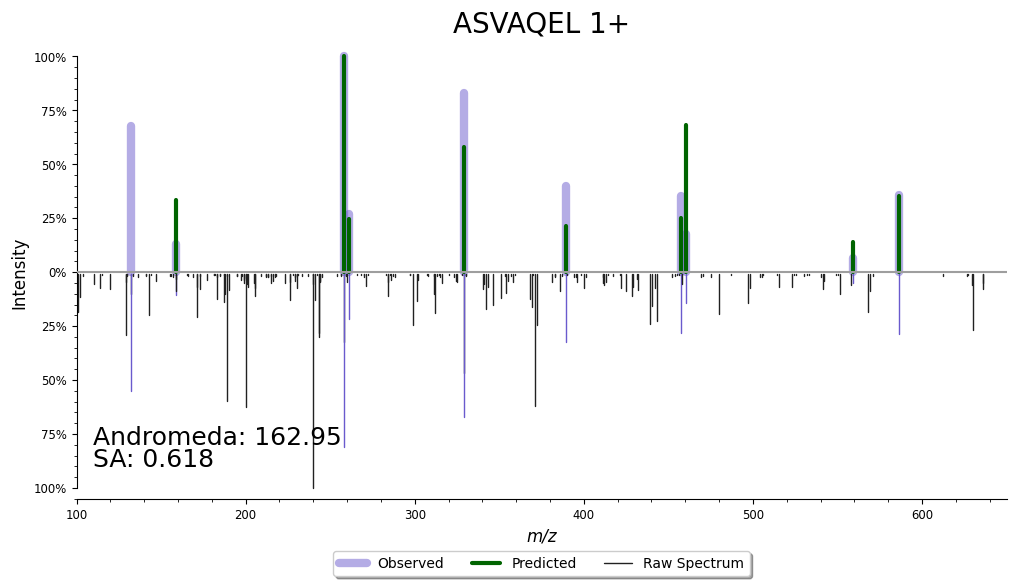

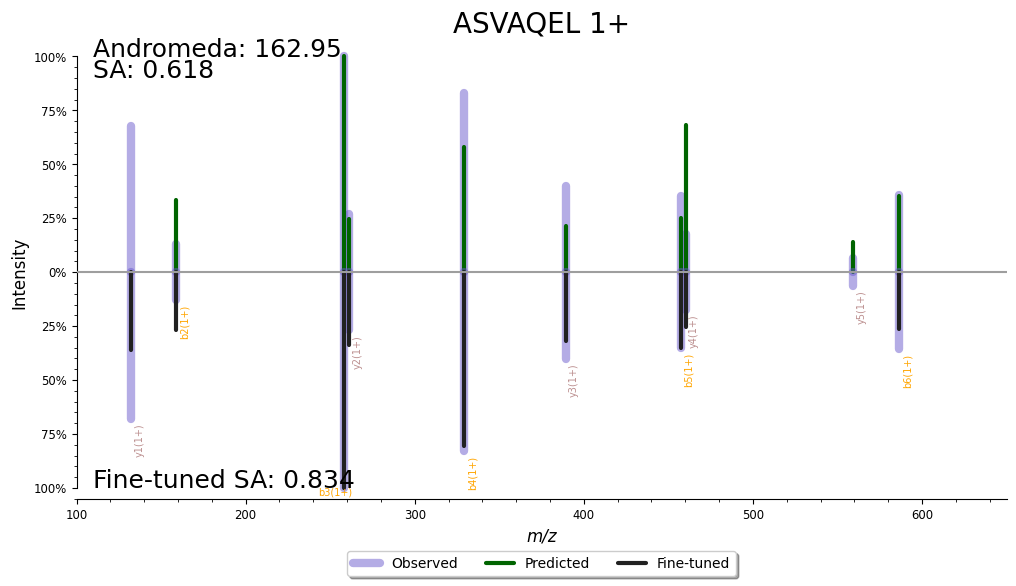

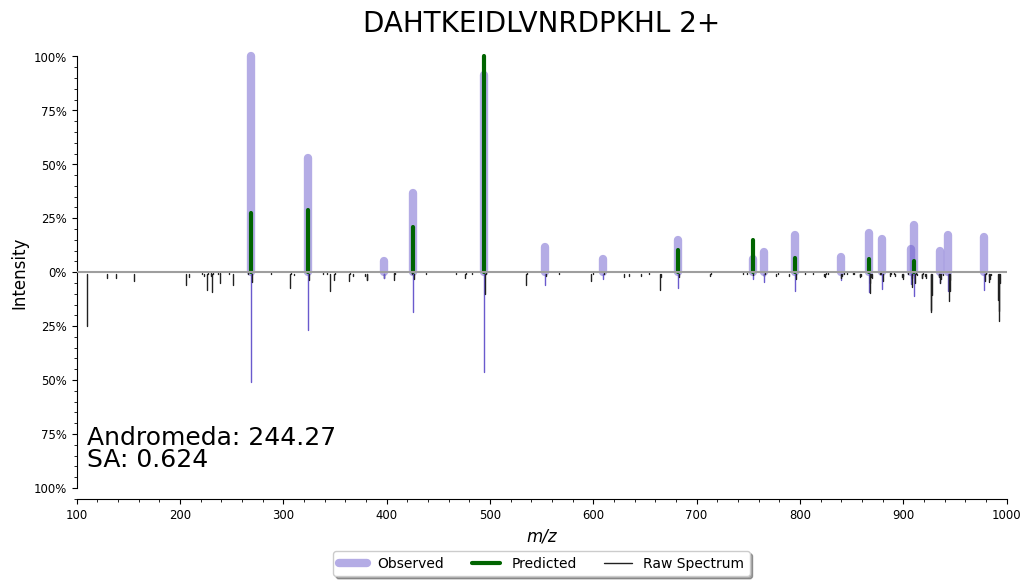

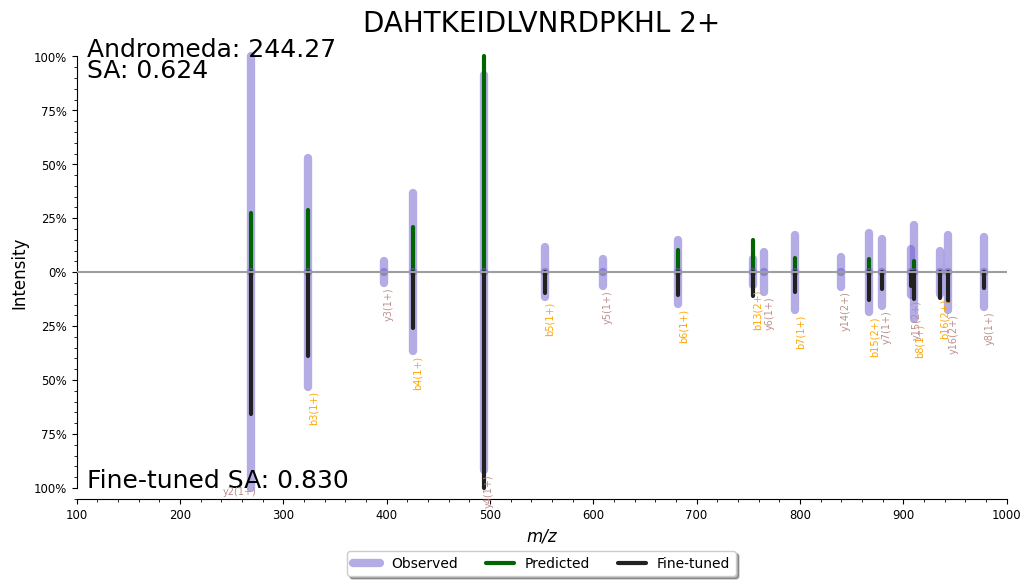

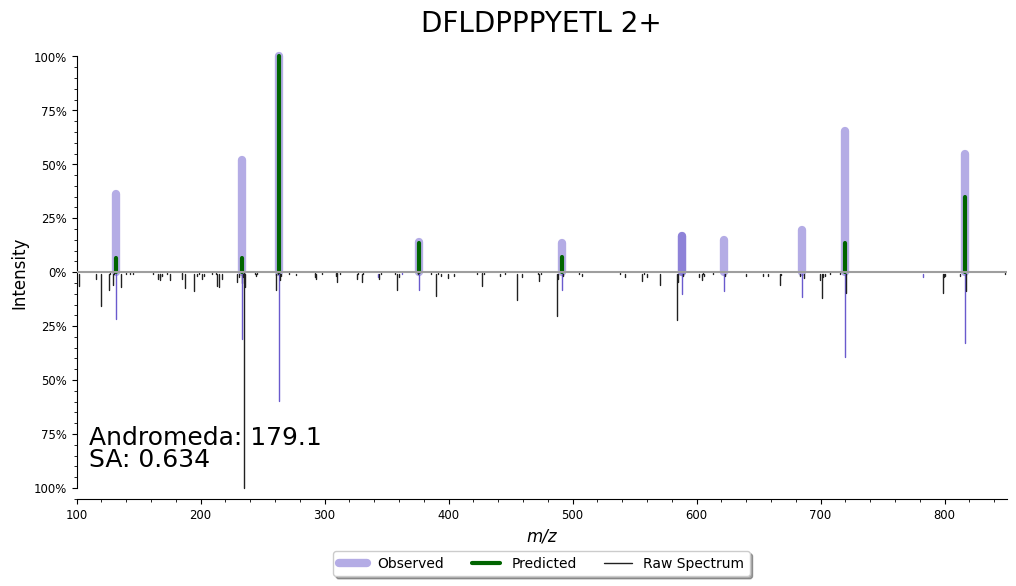

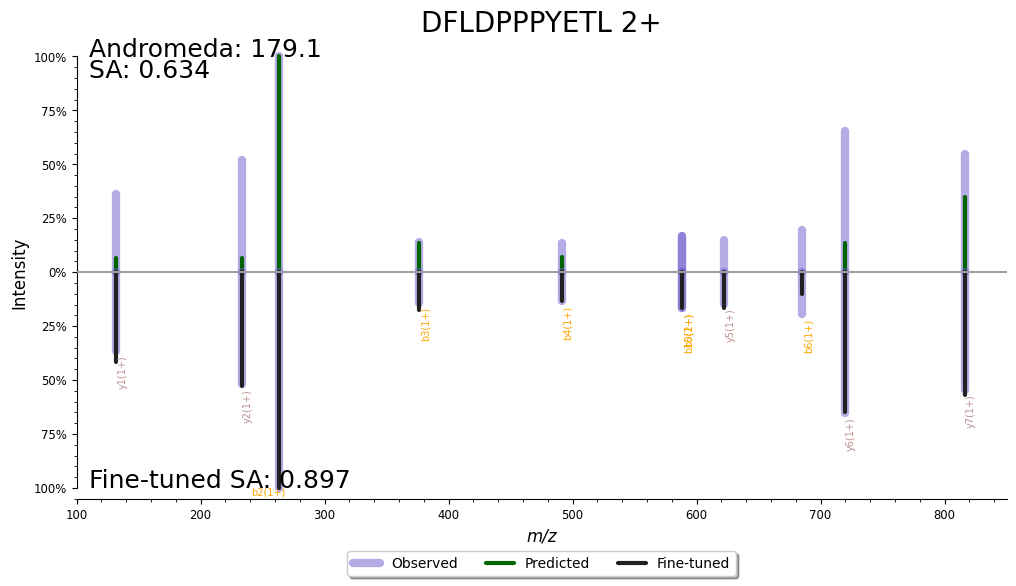

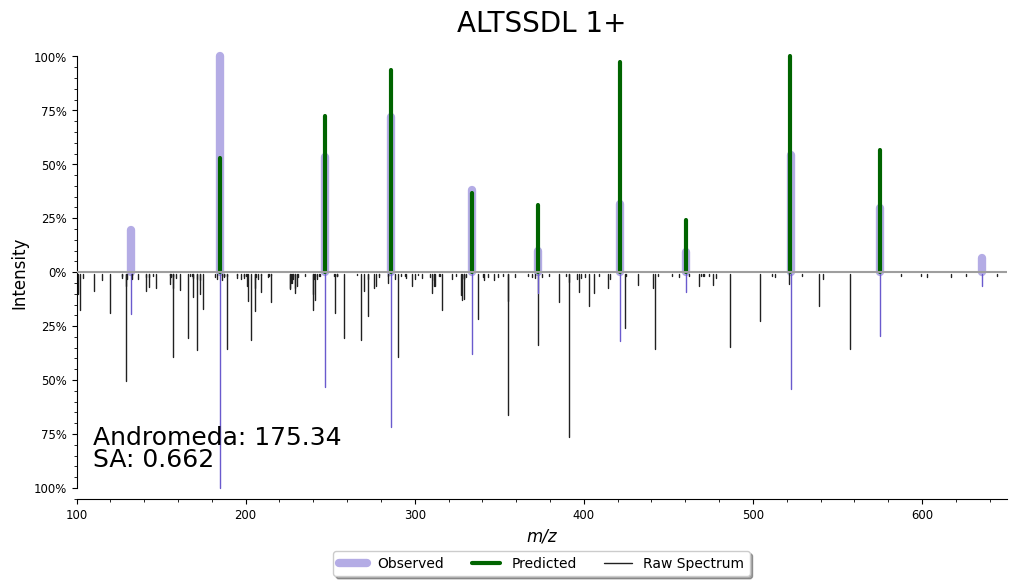

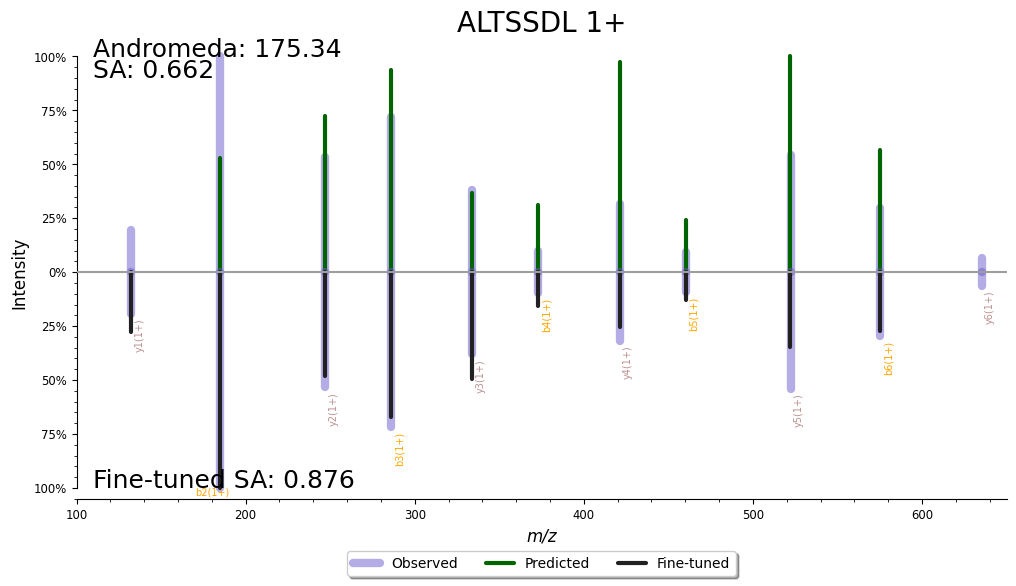

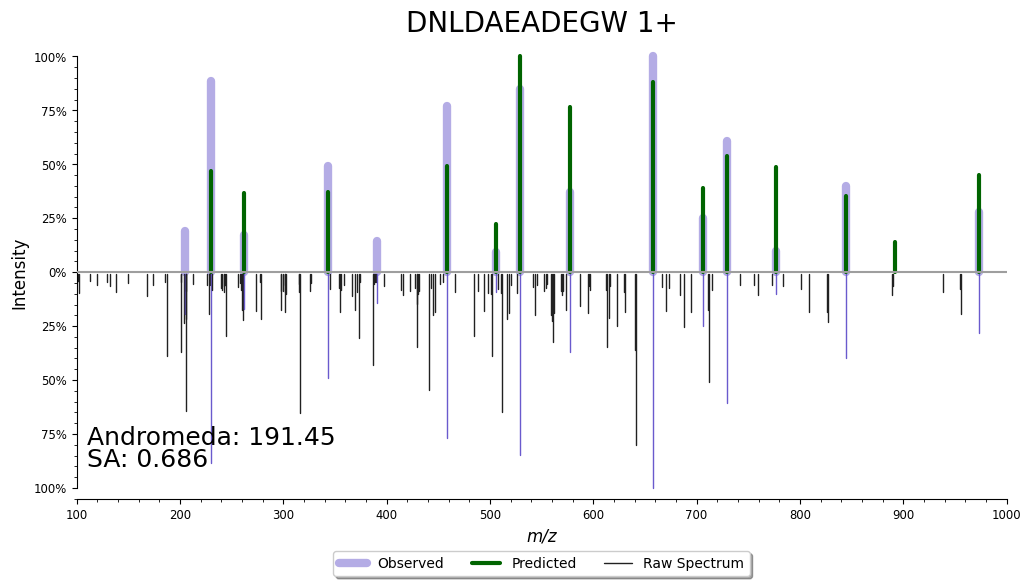

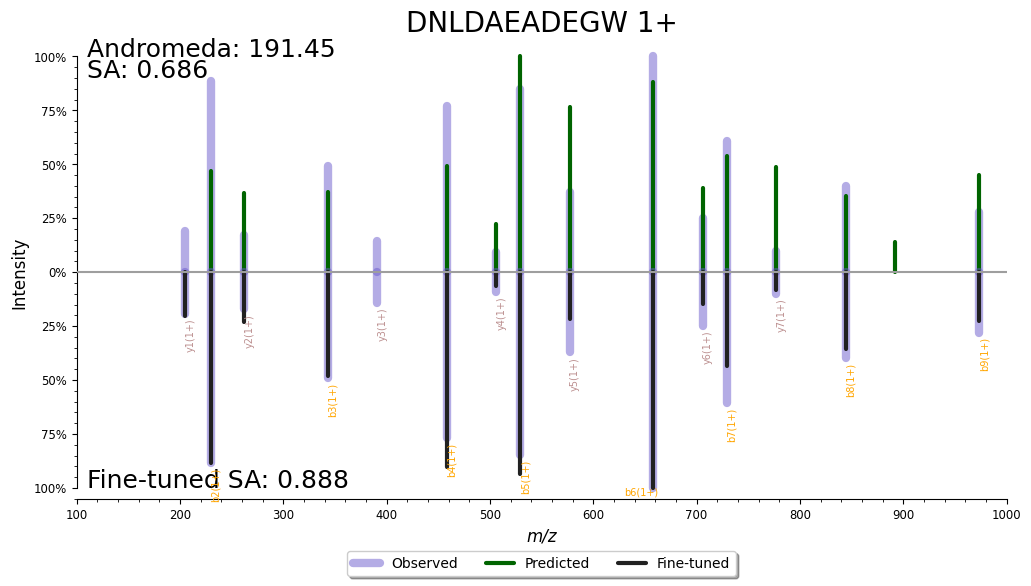

In [53]:
prosit_chymo_ids = [60168, 13280, 19453, 64772, 59236]
corr_max =           [650, 1000, 850, 650, 1000]

# prosit_chymo_ids = [59236]
# corr_max =           [1000]
for see_max, see in zip(corr_max, prosit_chymo_ids):
    plot_raw(see, x_max=see_max)
    plot_id(see, x_max=see_max)